## Import all the required modules


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model

        
import keras.backend as K
K.set_image_data_format('channels_last')

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras import applications
from keras.models import Sequential
import os,sys
import warnings
warnings.simplefilter("ignore")
from keras.applications.xception import Xception

import cv2
from keras.preprocessing.image import ImageDataGenerator

## Check image shape 

(194, 259, 3)


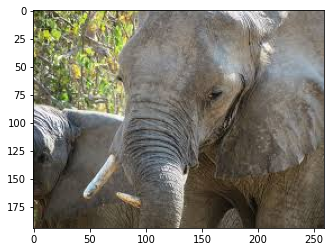

In [ ]:
img = cv2.imread('/content/drive/MyDrive/xception/data/dataset/train/African/af_tr1.jpg')
print(img.shape)
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [ ]:
train_dir = '/content/drive/MyDrive/xception/data/dataset/train'
validation_dir = '/content/drive/MyDrive/xception/data/dataset/validate'
test_dir = '/content/drive/MyDrive/xception/data/dataset/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       brightness_range=[0.2,1.0]
                                   )
validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       brightness_range=[0.2,1.0]
                                   )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(224, 224),
                                                        batch_size=5,
                                                        class_mode='categorical')

valid_generator = validation_datagen.flow_from_directory(validation_dir,
                                                                target_size=(224, 224),
                                                                batch_size=5,
                                                                class_mode='categorical')

test_generator = validation_datagen.flow_from_directory(test_dir,
                                                                target_size=(224, 224),
                                                                batch_size=5,
                                                                class_mode='categorical')


Found 840 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


# Xception model

In [ ]:
batch_size = 64

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

## Instantiate a base model with pre-trained weights.

In [ ]:
base_model = Xception(weights='imagenet',# Load weights pre-trained on ImageNet.
                      input_shape=(224, 224, 3), # Input equals image shape
                      include_top=False)  # Do not include the ImageNet classifier at the top.


83697664/83683744 [==============================] - 1s 0us/step


### Create a new model on top.

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

# add a global spatial average pooling layer
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# let's add 2 fully-connected layers
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- 
predictions = Dense(2, activation='softmax')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False
    
# this is the model we will train
xception = Model(inputs, outputs=predictions)

## Check model architecture

In [ ]:
xception.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                             

### Train the model on new data.

In [ ]:
xception.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
history = xception.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40,
                    verbose=1,
                    callbacks=[learning_rate_reduction]
)

Epoch 1/40
168/168 [==============================] - 411s 2s/step - loss: 0.6333 - accuracy: 0.6524 - val_loss: 0.5433 - val_accuracy: 0.7357 - lr: 1.0000e-04
Epoch 2/40
168/168 [==============================] - 338s 2s/step - loss: 0.5797 - accuracy: 0.7083 - val_loss: 0.5031 - val_accuracy: 0.7679 - lr: 1.0000e-04
Epoch 3/40
168/168 [==============================] - 334s 2s/step - loss: 0.5547 - accuracy: 0.7238 - val_loss: 0.4909 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 4/40
168/168 [==============================] - 332s 2s/step - loss: 0.5209 - accuracy: 0.7369 - val_loss: 0.4779 - val_accuracy: 0.7655 - lr: 1.0000e-04
Epoch 5/40
168/168 [==============================] - 329s 2s/step - loss: 0.5256 - accuracy: 0.7476 - val_loss: 0.4794 - val_accuracy: 0.7798 - lr: 1.0000e-04
Epoch 6/40
168/168 [==============================] - 329s 2s/step - loss: 0.4931 - accuracy: 0.7702 - val_loss: 0.5093 - val_accuracy: 0.7512 - lr: 1.0000e-04
Epoch 7/40
168/168 [====================

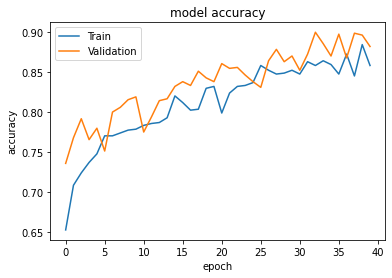

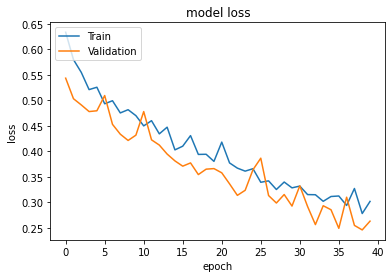

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
loss, acc = xception.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST, verbose=1)

37/37 [==============================] - 61s 2s/step - loss: 0.4398 - accuracy: 0.7730


In [ ]:
print(loss, acc)

0.43983888626098633 0.7729730010032654


## Save model in json format

In [ ]:
# save model
model_json = xception.to_json()
with open(os.path.join(os.path.abspath('/content/'), 'model.json'), 'w') as json_file:
        json_file.write(model_json)